# Project 6

Forecast annual S&P500 returns using lagged log price dividend ratio

1) full sample

2) out-of-sample

In [177]:
import yfinance as yf
import vectorbt as vbt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

### Get log price to dividend ratio

In [178]:
ticker = ["SPY"]

# Get Dividends using vbt API
div = vbt.YFData.download(ticker).get("Dividends")
div.index = pd.to_datetime(div.index.date)
# Annual Dividends
div_12m = div.rolling("365D").sum()

# Download the daily price from stocks
price = yf.download(ticker, progress=False)['Adj Close']
annual_returns = price.pct_change(252)
data = pd.DataFrame({"Price":price,"Annual_Dividends":div_12m,"Annual_Returns":annual_returns})

In [179]:
# Drop where Annual Dividends equal to 0
data["Annual_Dividends"] = data["Annual_Dividends"].replace(0,np.nan)
# Calculate Log P/D Ratio
data["Lagged_Log_PD_Ratio"] = np.log(data['Price'] / data['Annual_Dividends']).shift(1)
data = data.dropna()
data["PD_Ratio"] = data['Price'] / data['Annual_Dividends']

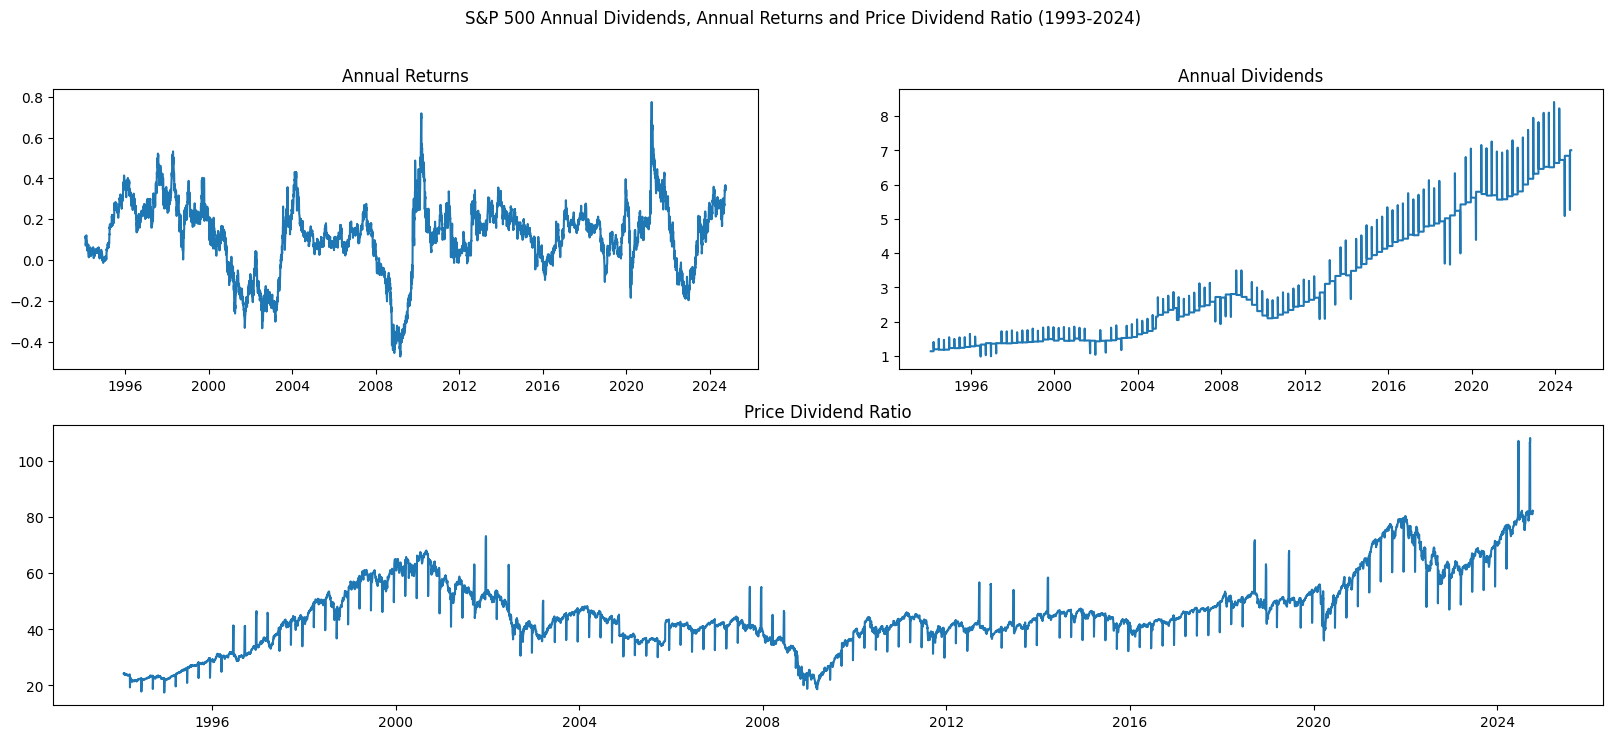

In [180]:
# Plot annual Dividends, annual Returns and PD Ratio over the years

plt.figure(figsize=(20,8))
plt.suptitle("S&P 500 Annual Dividends, Annual Returns and Price Dividend Ratio (1993-2024)")
ax1 = plt.subplot(222)
ax1.plot(data['Annual_Dividends'])
ax1.set_title('Annual Dividends')

ax2 = plt.subplot(221)
ax2.plot(data['Annual_Returns'])
ax2.set_title('Annual Returns')

ax3 = plt.subplot(212)
ax3.plot(data['PD_Ratio'])
ax3.set_title('Price Dividend Ratio')

plt.show()


# Model

### Full-Sample

Full-sample Root Mean Squared Error: 0.16427


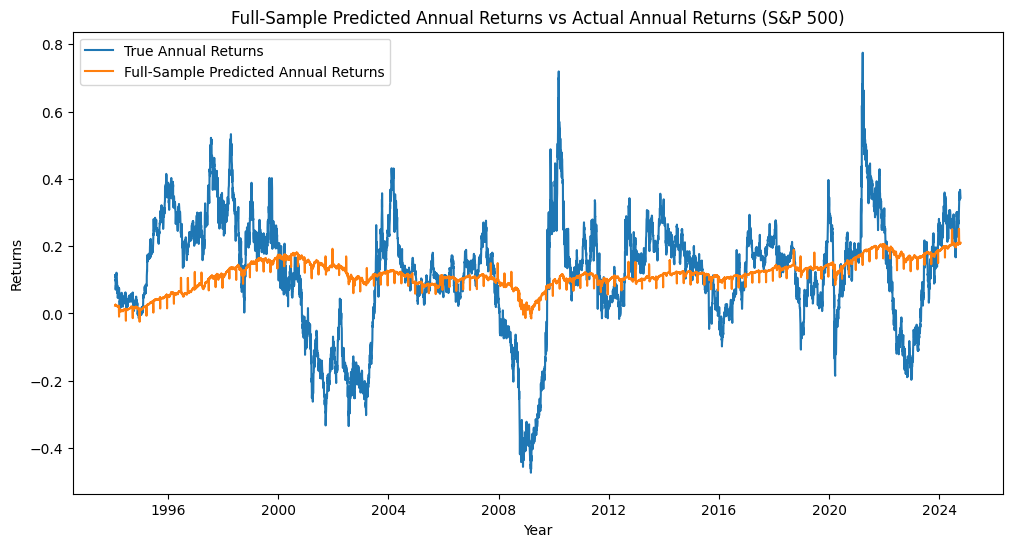

In [181]:
X = data[["Lagged_Log_PD_Ratio"]]
y = data["Annual_Returns"]

def fit_model(feat,target):
    model = LinearRegression()
    model.fit(feat, target)
    return model

m = fit_model(X,y)
y_pred_full_sample = m.predict(X)
rmse = root_mean_squared_error(y, y_pred_full_sample)
print(f"Full-sample Root Mean Squared Error: {rmse:.5f}")

plt.figure(figsize=(12, 6))
plt.plot(data.index, y, label="True Annual Returns")
plt.plot(data.index, y_pred_full_sample, label="Full-Sample Predicted Annual Returns")
plt.title("Full-Sample Predicted Annual Returns vs Actual Annual Returns (S&P 500)")
plt.xlabel("Year")
plt.ylabel("Returns")
plt.legend()
plt.show()

Forecast from 2011
Out-of-sample Mean Squared Error: 0.12004


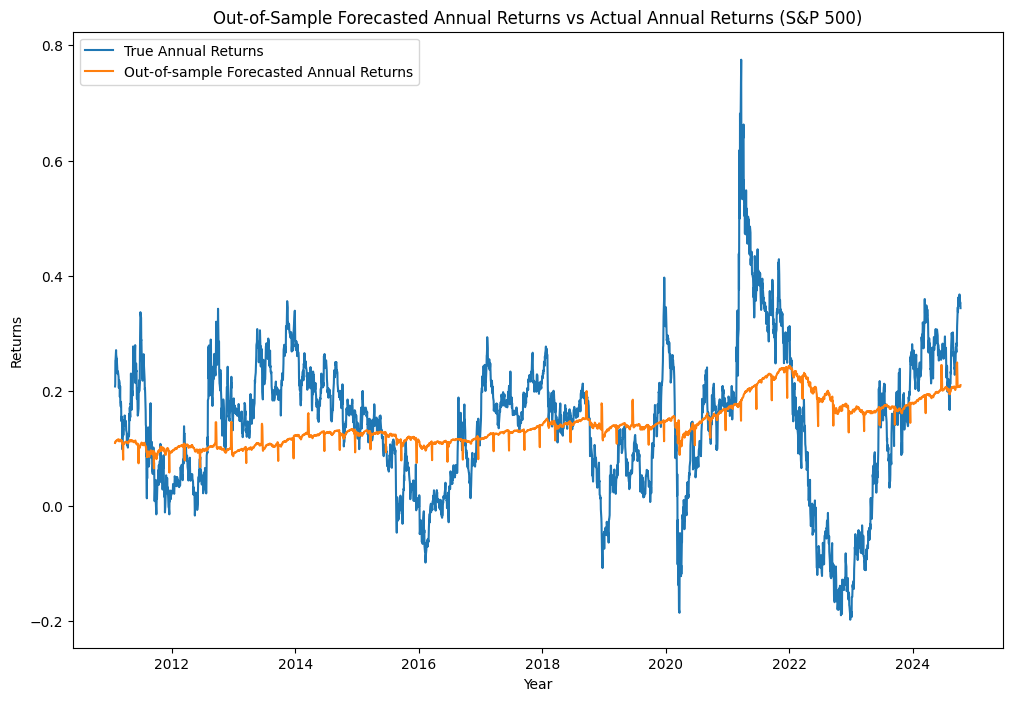

In [182]:
years = list(data.index.year.unique())
oos_years = 14
window_length = 252*(len(years)-oos_years)
print(f"Forecast from {years[-oos_years]}")
preds = []
y_true = y.iloc[window_length:len(data)+1].values

for i in range(window_length, len(data)):
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]
    
    model = fit_model(X_train,y_train)
    
    X_test = X.iloc[i:i+1]
    
    preds.append(model.predict(X_test)[0])
    
rmse = root_mean_squared_error(y_true, preds)
print(f"Out-of-sample Mean Squared Error: {rmse:.5f}")

plt.figure(figsize=(12, 8))
plt.plot(data.index[window_length:], y_true, label="True Annual Returns")
plt.plot(data.index[window_length:], preds, label="Out-of-sample Forecasted Annual Returns")
plt.title("Out-of-Sample Forecasted Annual Returns vs Actual Annual Returns (S&P 500)")
plt.xlabel("Year")
plt.ylabel("Returns")
plt.legend()
plt.show()